In [1]:
!git clone https://github.com/facebookresearch/detectron2.git
%cd detectron2

Cloning into 'detectron2'...
remote: Enumerating objects: 15725, done.
remote: Counting objects: 100% (448/448), done.
remote: Compressing objects: 100% (336/336), done.
remote: Total 15725 (delta 201), reused 296 (delta 103), pack-reused 15277
Receiving objects: 100% (15725/15725), 6.51 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (11316/11316), done.
/content/detectron2


In [2]:
!pip install -e .

Obtaining file:///content/detectron2
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 23.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 68.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 17.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61400 sha256=b5f3f7b855c2a3c0dc574564860ef1fa152a6907fd59af78cbc537c032796db9
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.9.3-py3-none-any.whl size=144554 sha256=60568d24a844f3dbfeb30f6b8d161c6320b01e13862619f

In [1]:
%cd detectron2

/content/detectron2


In [2]:
!curl -L "https://universe.roboflow.com/ds/0R3SQDOQLh?key=59Pan06uRl" --output roboflow.zip && unzip roboflow.zip -d csgo_dataset/ && rm roboflow.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2077      0 --:--:-- --:--:-- --:--:--  2080
100  151M  100  151M    0     0  12.5M      0  0:00:12  0:00:12 --:--:-- 17.8M
Archive:  roboflow.zip
 extracting: csgo_dataset/README.dataset.txt  
 extracting: csgo_dataset/README.roboflow.txt  
   creating: csgo_dataset/test/
 extracting: csgo_dataset/test/1015_jpg.rf.892bbbabbe892dc87510954fba973dd8.jpg  
 extracting: csgo_dataset/test/1019_jpg.rf.68cd2e3732ba2439036d5f05a21ca781.jpg  
 extracting: csgo_dataset/test/1040_jpg.rf.6205d5f0b581c2278edbb895be1d6df5.jpg  
 extracting: csgo_dataset/test/1043_jpg.rf.8c8bef2dbc09073f85eff672ce32b28c.jpg  
 extracting: csgo_dataset/test/1058_jpg.rf.f3323717e2efe0248ac26fb063be6966.jpg  
 extracting: csgo_dataset/test/1064_jpg.rf.2d5c2f102e9be017e081645a57e15359.jpg  
 extracting: csgo_dataset/test/1099_jpg.rf

In [3]:
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog
from google.colab.patches import cv2_imshow
from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
import torch

import os
import random
import json
import numpy as np
import cv2

from detectron2.utils.logger import setup_logger
setup_logger()

<Logger detectron2 (DEBUG)>

In [4]:
if torch.cuda.is_available():
  generator = torch.Generator('cuda').manual_seed(25)
else:
  generator = torch.Generator().manual_seed(25)

In [5]:
register_coco_instances("csgo_dataset_train", {}, "/content/detectron2/csgo_dataset/train/_annotations.coco.json", "/content/detectron2/csgo_dataset/train")
register_coco_instances("csgo_dataset_val", {}, "/content/detectron2/csgo_dataset/valid/_annotations.coco.json", "/content/detectron2/csgo_dataset/valid")
register_coco_instances("csgo_dataset_test", {}, "/content/detectron2/csgo_dataset/test/_annotations.coco.json", "/content/detectron2/csgo_dataset/test")

my_dataset_train_metadata = MetadataCatalog.get("csgo_dataset_train")
dataset_dicts = DatasetCatalog.get("csgo_dataset_train")

WARNING [06/06 19:17:07 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 19:17:07 d2.data.datasets.coco]: Loaded 2968 images in COCO format from /content/detectron2/csgo_dataset/train/_annotations.coco.json


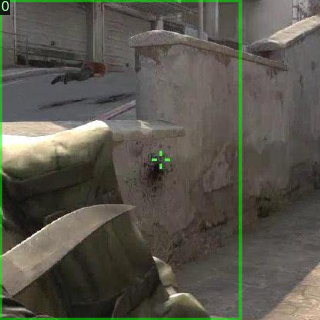

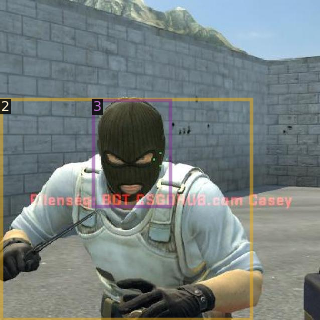

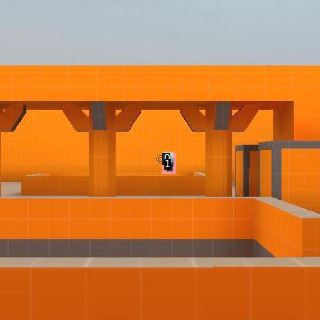

In [6]:
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("csgo_dataset_train",)
cfg.DATASETS.TEST = ("csgo_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001


cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1500 #adjust up if val mAP is still rising, adjust down if overfit
# cfg.SOLVER.STEPS = (1000, 1200)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 256
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(my_dataset_train_metadata.thing_classes)

cfg.TEST.EVAL_PERIOD = 500

In [8]:
class CocoTrainer(DefaultTrainer):

  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):

    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"

    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [9]:
# os.environ['CUDA_LAUNCH_BLOCKING'] = 1
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 19:17:31 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:00, 215MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}


[06/06 19:17:32 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/06 19:17:43 d2.utils.events]:  eta: 0:07:32  iter: 19  total_loss: 2.329  loss_cls: 1.863  loss_box_reg: 0.3791  loss_rpn_cls: 0.0501  loss_rpn_loc: 0.04312    time: 0.3016  last_time: 0.3139  data_time: 0.0174  last_data_time: 0.0106   lr: 1.9981e-05  max_mem: 2663M
[06/06 19:17:52 d2.utils.events]:  eta: 0:07:24  iter: 39  total_loss: 1.938  loss_cls: 1.407  loss_box_reg: 0.4036  loss_rpn_cls: 0.05761  loss_rpn_loc: 0.04555    time: 0.2948  last_time: 0.2454  data_time: 0.0083  last_data_time: 0.0078   lr: 3.9961e-05  max_mem: 2664M
[06/06 19:17:57 d2.utils.events]:  eta: 0:07:18  iter: 59  total_loss: 1.437  loss_cls: 0.7557  loss_box_reg: 0.4702  loss_rpn_cls: 0.04088  loss_rpn_loc: 0.08077    time: 0.2954  last_time: 0.3056  data_time: 0.0079  last_data_time: 0.0084   lr: 5.9941e-05  max_mem: 2665M
[06/06 19:18:03 d2.utils.events]:  eta: 0:07:11  iter: 79  total_loss: 0.9032  loss_cls: 0.4408  loss_box_reg: 0.3903  loss_rpn_cls: 0.04251  loss_rpn_loc: 0.02376    time: 0.2920  

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:20:07 d2.evaluation.evaluator]: Inference done 11/160. Dataloading: 0.0008 s/iter. Inference: 0.0339 s/iter. Eval: 0.0003 s/iter. Total: 0.0350 s/iter. ETA=0:00:05
[06/06 19:20:12 d2.evaluation.evaluator]: Inference done 151/160. Dataloading: 0.0014 s/iter. Inference: 0.0341 s/iter. Eval: 0.0003 s/iter. Total: 0.0359 s/iter. ETA=0:00:00
[06/06 19:20:13 d2.evaluation.evaluator]: Total inference time: 0:00:05.612257 (0.036208 s / iter per device, on 1 devices)
[06/06 19:20:13 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.034099 s / iter per device, on 1 devices)
[06/06 19:20:13 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 19:20:13 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[06/06 19:20:13 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.29s)
creating index...
index created!
[06/06 19:20:13 d2.evaluati

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:22:42 d2.evaluation.evaluator]: Inference done 11/160. Dataloading: 0.0010 s/iter. Inference: 0.0348 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:05
[06/06 19:22:47 d2.evaluation.evaluator]: Inference done 150/160. Dataloading: 0.0014 s/iter. Inference: 0.0345 s/iter. Eval: 0.0003 s/iter. Total: 0.0362 s/iter. ETA=0:00:00
[06/06 19:22:48 d2.evaluation.evaluator]: Total inference time: 0:00:05.645366 (0.036422 s / iter per device, on 1 devices)
[06/06 19:22:48 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.034427 s / iter per device, on 1 devices)
[06/06 19:22:48 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 19:22:48 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[06/06 19:22:48 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[06/06 19:22:48 d2.evaluati

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:25:16 d2.evaluation.evaluator]: Inference done 11/160. Dataloading: 0.0010 s/iter. Inference: 0.0339 s/iter. Eval: 0.0003 s/iter. Total: 0.0353 s/iter. ETA=0:00:05
[06/06 19:25:21 d2.evaluation.evaluator]: Inference done 151/160. Dataloading: 0.0014 s/iter. Inference: 0.0340 s/iter. Eval: 0.0003 s/iter. Total: 0.0358 s/iter. ETA=0:00:00
[06/06 19:25:21 d2.evaluation.evaluator]: Total inference time: 0:00:05.600044 (0.036129 s / iter per device, on 1 devices)
[06/06 19:25:21 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.034114 s / iter per device, on 1 devices)
[06/06 19:25:21 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 19:25:21 d2.evaluation.coco_evaluation]: Saving results to coco_eval/coco_instances_results.json
[06/06 19:25:21 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[06/06 19:25:21 d2.evaluati

In [15]:
!cp -r /content/detectron2/output /content/drive/MyDrive/cmp719_project/detectrons/csgo_model

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [11]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set a custom testing threshold
predictor = DefaultPredictor(cfg)

[06/06 19:25:29 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...


WARNING [06/06 19:29:35 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 19:29:35 d2.data.datasets.coco]: Loaded 160 images in COCO format from /content/detectron2/csgo_dataset/valid/_annotations.coco.json


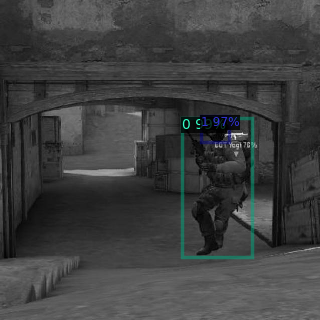

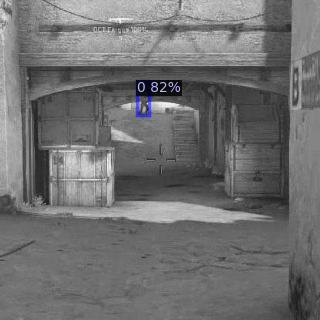

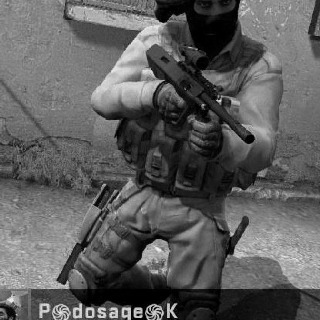

In [17]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = DatasetCatalog.get("csgo_dataset_val")
for d in random.sample(dataset_dicts, 3):
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)  # format is documented at https://detectron2.readthedocs.io/tutorials/models.html#model-output-format
    v = Visualizer(im[:, :, ::-1],
                   metadata=my_dataset_train_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
    )
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [18]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("csgo_dataset_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "csgo_dataset_val")
print(inference_on_dataset(predictor.model, val_loader, evaluator))
# another equivalent way to evaluate the model is to use `trainer.test`

WARNING [06/06 19:29:37 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[06/06 19:29:37 d2.data.datasets.coco]: Loaded 160 images in COCO format from /content/detectron2/csgo_dataset/valid/_annotations.coco.json
[06/06 19:29:37 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 19:29:37 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[06/06 19:29:37 d2.data.common]: Serializing 160 elements to byte tensors and concatenating them all ...
[06/06 19:29:37 d2.data.common]: Serialized dataset takes 0.05 MiB
[06/06 19:29:37 d2.evaluation.evaluator]: Start inference on 160 batches


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


[06/06 19:29:38 d2.evaluation.evaluator]: Inference done 11/160. Dataloading: 0.0010 s/iter. Inference: 0.0346 s/iter. Eval: 0.0002 s/iter. Total: 0.0359 s/iter. ETA=0:00:05
[06/06 19:29:43 d2.evaluation.evaluator]: Inference done 150/160. Dataloading: 0.0014 s/iter. Inference: 0.0344 s/iter. Eval: 0.0003 s/iter. Total: 0.0361 s/iter. ETA=0:00:00
[06/06 19:29:43 d2.evaluation.evaluator]: Total inference time: 0:00:05.626608 (0.036301 s / iter per device, on 1 devices)
[06/06 19:29:43 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:05 (0.034323 s / iter per device, on 1 devices)
[06/06 19:29:43 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 19:29:43 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/06 19:29:43 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
[06/06 19:29:43 d2.evaluatio